# 載入資料

In [ ]:
!gdown --id '1oT0qwtcfCACtQ6vzNWhAbAxrThvbS73B' --output 'cabbage.xlsx'
!gdown --id '1-2GdInJS8I5QOO3nJCKC9Bc6YG2j6o5m' --output 'weather.csv'
!gdown --id '1iKa9g_ZvDJE5EdYmlL-FA4AoVnKhMPKd' --output 'mvrs.csv'

# 安裝套件

In [ ]:
!pip install prophet
# !pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import pmdarima as pm
from prophet import Prophet

In [ ]:
%%capture
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# 檢視資料

## 甘藍

,price,quantity
date,,
2011-01-01,8.645042,297507
2011-01-02,8.257309,272084
2011-01-04,9.171932,235652
2011-01-05,9.839765,203173
2011-01-06,10.080478,194846


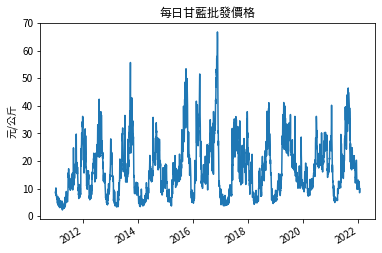

In [ ]:
df_c = pd.read_excel('cabbage.xlsx', index_col='date', parse_dates=True)['2011':]
display(df_c.head())
df_c.price.plot()
plt.title('每日甘藍批發價格')
plt.ylabel('元/公斤')
plt.xlabel('')
plt.show()

In [ ]:
df_c['pq'] = df_c.price * df_c.quantity
df_c = df_c.resample('W-Fri', label='right').sum()
df_c.price = df_c.pq / df_c.quantity
df_c = df_c.drop(columns=['quantity', 'pq'])

,price
date,
2011-01-07,9.229535
2011-01-14,8.637490
2011-01-21,6.727316
2011-01-28,5.659670
2011-02-04,6.425445


,price
date,
2021-12-31,11.118384
2022-01-07,11.310858
2022-01-14,11.804070
2022-01-21,9.820779
2022-01-28,9.356194


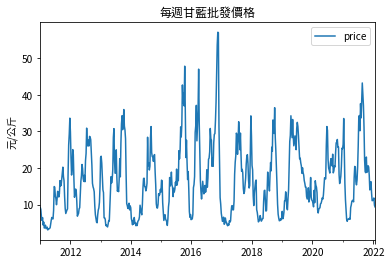

In [ ]:
display(df_c.head())
display(df_c.tail())
df_c.plot()
plt.title('每週甘藍批發價格')
plt.ylabel('元/公斤')
plt.xlabel('')
plt.show()

## 甘藍育苗

In [ ]:
df_m = pd.read_csv('mvrs.csv', index_col='date', parse_dates=True)
df_m.head() # 千株

,LA_num
date,
2011-01-05,6020.64
2011-01-15,5809.97
2011-01-25,6209.84
2011-02-05,4715.74
2011-02-15,4997.61


In [ ]:
df_m = df_m.resample('W-Fri', label='right').nearest()
display(df_m.head())
df_m.tail(10)

,LA_num
date,
2011-01-07,6020.64
2011-01-14,5809.97
2011-01-21,6209.84
2011-01-28,6209.84
2011-02-04,4715.74


,LA_num
date,
2021-10-29,7487.16
2021-11-05,7919.72
2021-11-12,8300.18
2021-11-19,8300.18
2021-11-26,4823.72
2021-12-03,4471.26
2021-12-10,3320.96
2021-12-17,3320.96
2021-12-24,3315.16


In [ ]:
df_m = df_m.shift(9)
display(df_m.head())
df_m.tail()

,LA_num
date,
2011-01-07,NaN
2011-01-14,NaN
2011-01-21,NaN
2011-01-28,NaN
2011-02-04,NaN


,LA_num
date,
2021-12-03,6514.52
2021-12-10,6514.52
2021-12-17,6806.48
2021-12-24,7487.16
2021-12-31,7487.16


## 天氣

In [ ]:
cols = ['ObsTime', 'Temperature', 'Precp']
df_w = pd.read_csv('weather.csv', usecols=cols, index_col='ObsTime', parse_dates=True)
df_w.index.name = 'date'
df_w.head() # ℃、mm

,Temperature,Precp
date,,
2011-01-01,11.3,0.0
2011-01-02,14.1,0.0
2011-01-03,13.5,3.0
2011-01-04,13.1,0.1
2011-01-05,16.8,1.0


In [ ]:
df_w = df_w.resample('W-Fri', label='right').mean()
display(df_w.head())
df_w.tail()

,Temperature,Precp
date,,
2011-01-07,13.428571,0.714286
2011-01-14,13.442857,7.614286
2011-01-21,14.014286,1.000000
2011-01-28,15.071429,0.385714
2011-02-04,14.071429,0.985714


,Temperature,Precp
date,,
2021-12-03,19.185714,1.857143
2021-12-10,19.514286,2.785714
2021-12-17,20.514286,0.785714
2021-12-24,18.300000,3.428571
2021-12-31,15.700000,0.714286


## 合併

In [ ]:
df = pd.concat([df_c, df_m, df_w], axis=1)
# df = df.dropna()
df = df['2011-03-11':'2021']
dfall = df.copy()
display(df.head())
df.tail()

,price,LA_num,Temperature,Precp
date,,,,
2011-03-11,4.351267,6020.64,15.585714,8.000000
2011-03-18,3.421378,5809.97,17.071429,0.542857
2011-03-25,3.442451,6209.84,17.428571,0.128571
2011-04-01,3.818407,6209.84,16.357143,8.342857
2011-04-08,3.057363,4715.74,19.542857,0.428571


,price,LA_num,Temperature,Precp
date,,,,
2021-12-03,14.733079,6514.52,19.185714,1.857143
2021-12-10,16.248890,6514.52,19.514286,2.785714
2021-12-17,13.145006,6806.48,20.514286,0.785714
2021-12-24,11.053453,7487.16,18.300000,3.428571
2021-12-31,11.118384,7487.16,15.700000,0.714286


In [ ]:
df['ln_price'] = np.log(df.price)

In [ ]:
print(df.isna().sum())

price          0
LA_num         0
Temperature    0
Precp          0
ln_price       0
dtype: int64


# 切割資料

In [ ]:
tr_splits = ['2020-12', '2021-02', '2021-04',
             '2021-06', '2021-08', '2021-10', '2021-12']
va_splits = ['2021-01', '2021-03', '2021-05',
             '2021-07', '2021-09', '2021-11']
trs, vas = [], []

for i in range(6):
    trs.append(df[:tr_splits[i]])
    vas.append(df[va_splits[i]:tr_splits[i+1]])

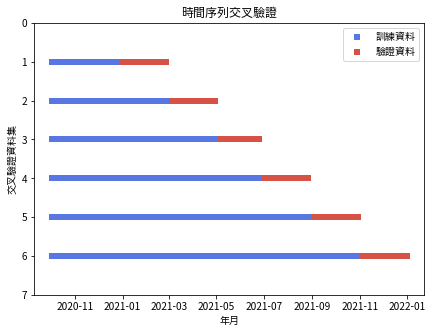

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
for ii, (r, v) in enumerate(zip(trs, vas), 1):
    l1 = ax.scatter(r['2020-10':].index, [ii]*len(r['2020-10':]),
                    c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(v.index, [ii]*len(v),
                    c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(title='時間序列交叉驗證', ylim=[7, 0],
           xlabel='年月', ylabel='交叉驗證資料集',)
    ax.legend([l1, l2], ['訓練資料', '驗證資料'])

# 資料分析

## Visualization

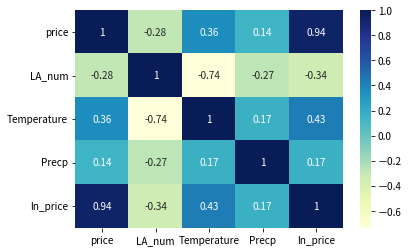

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

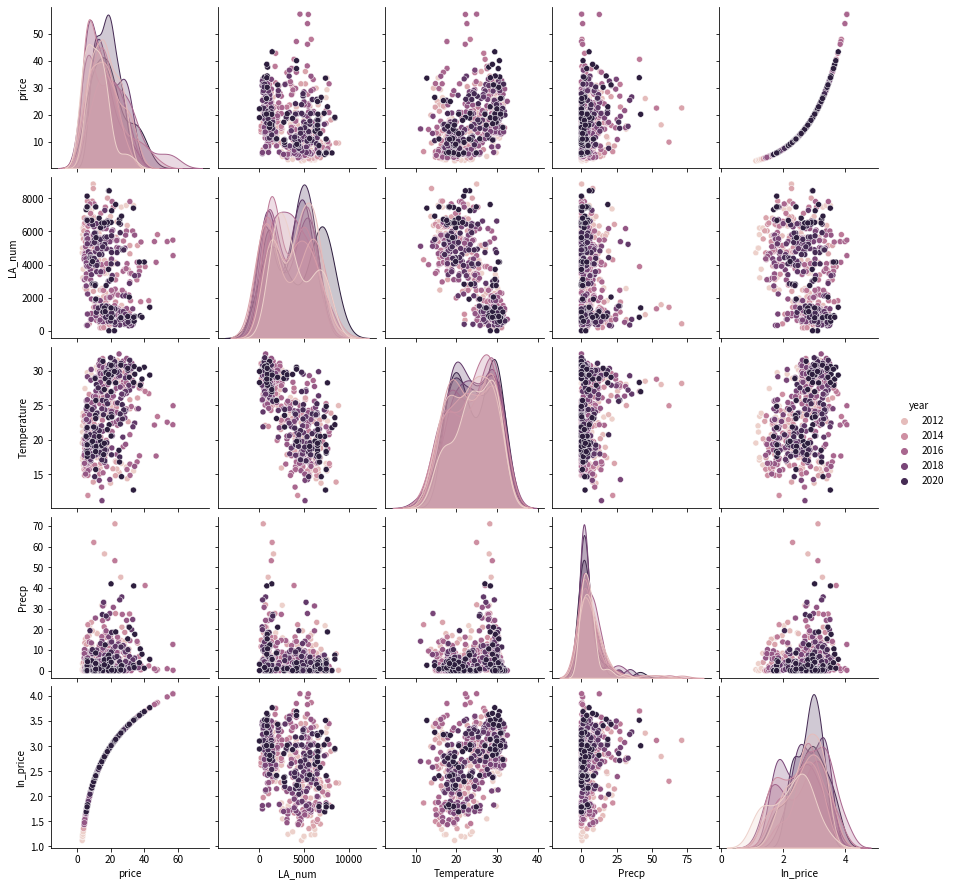

In [ ]:
df['year'] = df.index.year
sns.pairplot(df, hue='year')
plt.show()

## Decomposition

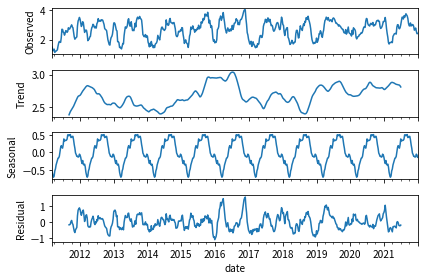

In [ ]:
decomp_results = seasonal_decompose(df.ln_price)
decomp_results.plot()
plt.show()

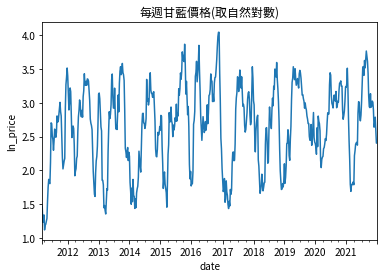

In [ ]:
df.ln_price.plot()
plt.title('每週甘藍價格(取自然對數)')
plt.ylabel('ln_price')
plt.show()

## ADF TEST

In [ ]:
# print(adfuller(df.price))
print(adfuller(df.ln_price))

(-6.86993697048007, 1.524778106779821e-09, 6, 558, {'1%': -3.4421235439968862, '5%': -2.866733577794069, '10%': -2.569536010842615}, -218.19823520770672)


## ACF與PACF

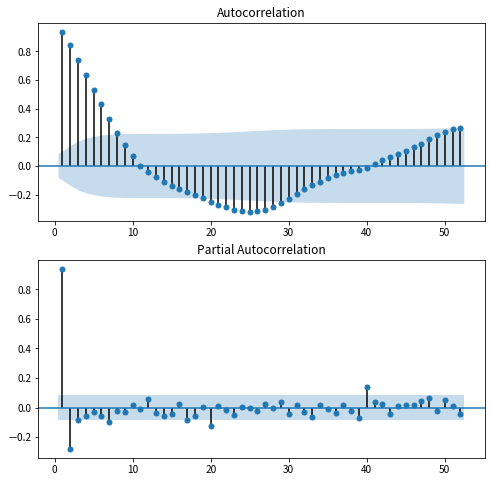

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# Make ACF plot
plot_acf(df.ln_price, lags=52, zero=False, ax=ax1)

# Make PACF plot
plot_pacf(df.ln_price, lags=52, zero=False, ax=ax2, method='ywm')
plt.show()

# 模型

## SARIMAX
$SARIMAX(p, d, q) \times (P, D, Q): Seasonal + ARIMA + Exogenous$

$AR(p): Y_t = \beta_0 + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \dots + \beta_pY_{t-p} + u_t$

$MR(q): Y_t = \theta_0 + \theta_1u_{t-1} + \theta_2u_{t-2} + \dots + \theta_qu_{t-q} + u_t$

$ARIMR(p, d, q): (1 - \sum_{i=1}^p \beta_i L^i)(1-L)^dY_t = (1 - \sum_{i=1}^q \theta_i L^i)u_t$, where $L$ stands for Lag operator.

In [ ]:
trs[-1].tail()

,price,LA_num,Temperature,Precp,ln_price
date,,,,,
2021-10-01,18.968285,0.00,28.328571,3.071429,2.942768
2021-10-08,18.718567,3711.16,29.514286,0.000000,2.929516
2021-10-15,23.008165,7630.39,28.285714,18.714286,3.135849
2021-10-22,18.830983,8461.22,23.228571,7.500000,2.935504
2021-10-29,19.119969,8461.22,22.200000,5.571429,2.950733


In [ ]:
%%capture
results = []
#for tr in trs:
    #result = pm.auto_arima(tr.ln_price, X=tr[['LA_num', 'Temperature', 'Precp']], seasonal=True, D=1, m=52)
    ##WEEK:  SARIMAX(3, 0, 0)x(2, 1, 0, 52) 
    ##MONTH: SARIMAX(2, 0, 0)x(2, 1, 0, 12)
for tr in trs[-1:]:
    model = SARIMAX(tr.ln_price, exog=tr[['LA_num', 'Temperature', 'Precp']],
                    order=(3, 0, 0), seasonal_order=(2, 1, 0, 52))
    result = model.fit()
    results.append(result)

KeyboardInterrupt: ignored

In [ ]:
print(results[-1].summary())

IndexError: ignored

### 訓練資料

In [ ]:
def sarimax_forcast(tr, va=pd.DataFrame(), exo=['LA_num', 'Temperature', 'Precp'], ci=0.68):
    """
    Args:
      tr: Training Set
      va: Validation Set
      exo: Exog. List
      ci: Confidence Interval
    Returns:
      fcst: Forcast Dataframe
    """
    # model = SARIMAX(tr.ln_price, exog=tr[exo],
    #                 order=(3,0,0), seasonal_order=(2, 1, 0, 52))
    # result = model.fit()
    result = results[-1]

    preiods = len(va)
    if preiods == 0:
        predicted = result.get_prediction()
    else:
        predicted = result.get_forecast(steps=preiods, exog=va[exo])

    mean = pd.DataFrame({'predicted_mean':predicted.predicted_mean})
    conf = predicted.conf_int(alpha=1-ci)  # 68%
    fcst = pd.concat([mean, conf], axis=1)
    return fcst

In [ ]:
# sarimax_forcast(trs[-1])

### 驗證資料

In [ ]:
def connectpoint(tr):
    """
    Args:
      tr: Training Set
    Returns:
      lastp: Price of last date
      lastci: Price lower & upper Bound of last date
    """
    lastp = tr.price[-1:]
    lastci = tr[['price', 'price']][-1:]
    lastci.columns = ['lower price', 'upper price']
    lastci.index.name = 'ds'
    return lastp, lastci

In [ ]:
def fanchart(tr, va, fcst30, fcst60, start='2020'):
    """
    Args:
      tr: Training Set
      va: Validation Set
      fcst30: DataFrame of 30% CI
      fcst60: DataFrame of 60% CI
      start: Start Time 
    Returns:
      plt.show()
    """
    lastp, lastci = connectpoint(tr)

    yhat = fcst30.iloc[:, 0]

    point_est = np.exp(yhat)
    point_est = point_est.append(lastp).sort_index()

    fig, ax = plt.subplots()
    tr[start:].price.plot(ax=ax, legend=False)
    va.price.append(lastp).sort_index().plot(color='C0')

    point_est.plot()
    plt.axvspan(point_est.index.min(), point_est.index.max(), color='grey', alpha=0.3)

    conf30 = fcst30.iloc[:, 1:]
    conf60 = fcst60.iloc[:, 1:]
    confs = [conf30, conf60]    

    for i, conf in enumerate(confs):
        conf = np.exp(conf)
        conf.columns = ['lower price', 'upper price']
        conf = conf.append(lastci).sort_index()
        plt.fill_between(conf.index, conf['lower price'], conf['upper price'],
                         color='xkcd:tomato red', alpha=(1-i/2.5), facecolor='black')

    ax.set_xlabel('')
    ax.set_ylabel('元/公斤')
    ax.set_ylim(0, 50)
    return plt.show()

In [ ]:
fcst30 = sarimax_forcast(tr=trs[-1], va=vas[-1], ci=0.3)
fcst60 = sarimax_forcast(tr=trs[-1], va=vas[-1], ci=0.6)

fanchart(trs[-1], vas[-1], fcst30, fcst60)

In [ ]:
results[-1].plot_diagnostics(figsize=(9,6))
plt.show()

## fbporphet
$y(t) = g(t) + s(t) + h(t) + e(t)$

$g(t)$: trend models non-periodic changes.

$s(t)$: seasonality presents periodic changes.

$h(t)$: effects of holidays with irregular schedules.

$e(t)$: covers idiosyncratic changes not accommodated by the model.

### 設定資料

In [ ]:
def setdata(df):
    """
    Args:
      df: Source DataFrame
    Returns:
      df: Result DataFrame
    """
    df = df.reset_index()
    df.columns = ['ds', 'price', 'LA_num', 'Temperature', 'Precp', 'ln_price']
    df['y'] = df.ln_price
    return df

In [ ]:
trps, vaps = [], []
for tr, va in zip(trs, vas):
    trps.append(setdata(tr))
    vaps.append(setdata(va))

### 訓練資料

In [ ]:
def prophet_forecast(tr, va=pd.DataFrame(), exo=['LA_num', 'Temperature', 'Precp'], ci=0.68):
    """
    Args:
      tr: Training Set
      va: Validation Set
      exo: Exog. List
      ci: Confidence Interval
    Returns:
      fcst: Forecast Dataframe
    """
    m = Prophet(seasonality_mode='multiplicative', interval_width=ci,
                yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    for x in exo:
        m.add_regressor(x)
    cols = ['ds', 'y'] + exo
    m.fit(tr[cols])

    preiods = len(va)
    if preiods == 0:
        predict = m.make_future_dataframe(periods=preiods, freq='W-Fri', include_history=True)
        for x in exo:
            predict[x] = tr[[x]].reset_index(drop=True)
    else:
        predict = m.make_future_dataframe(periods=preiods, freq='W-Fri', include_history=False)
        for x in exo:
            predict[x] = va[[x]].reset_index(drop=True)
    fcst = m.predict(predict)
    fcst = fcst.set_index(fcst.ds, drop=True)
    return fcst[['yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
def fanchart(tr, va, fcst30, fcst60, start='2020', title='扇形圖'):
    """
    Args:
      tr: Training Set
      va: Validation Set
      fcst30: DataFrame of 30% CI
      fcst60: DataFrame of 60% CI
      start: Start Time 
    Returns:
      plt.show()
    """
    lastp, lastci = connectpoint(tr)

    yhat = fcst30.iloc[:, 0]

    point_est = np.exp(yhat)
    point_est = point_est.append(lastp).sort_index()

    fig, ax = plt.subplots()
    tr[start:].price.plot(ax=ax, legend=False)
    va.price.append(lastp).sort_index().plot(color='C0')

    point_est.plot()
    plt.axvspan(point_est.index.min(), point_est.index.max(), color='grey', alpha=0.3)

    conf30 = fcst30.iloc[:, 1:]
    conf60 = fcst60.iloc[:, 1:]
    confs = [conf30, conf60]    

    for i, conf in enumerate(confs):
        conf = np.exp(conf)
        conf.columns = ['lower price', 'upper price']
        conf = conf.append(lastci).sort_index()
        plt.fill_between(conf.index, conf['lower price'], conf['upper price'],
                         color='xkcd:tomato red', alpha=(1-i/2.5), facecolor='black')

    ax.set_xlabel('')
    ax.set_ylabel('元/公斤')
    ax.set_ylim(0, 50)
    ax.set_title(title)
    return plt.show()

In [ ]:
# prophet_forecast(trps[-1])

### 驗證資料 - 無外生變數

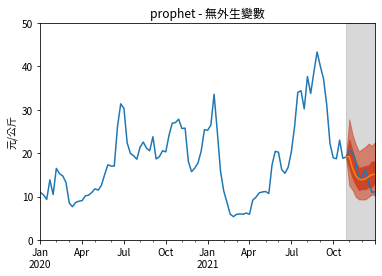

In [ ]:
fcst30 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=[], ci=0.3)
fcst60 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=[], ci=0.6)

fanchart(trs[-1], vas[-1], fcst30, fcst60, title='prophet - 無外生變數')

## 驗證資料 - 僅天氣資料

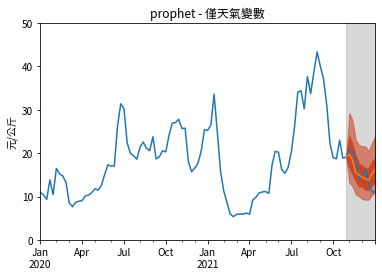

In [ ]:
fcst30 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=['Temperature', 'Precp'], ci=0.3)
fcst60 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=['Temperature', 'Precp'], ci=0.6)

fanchart(trs[-1], vas[-1], fcst30, fcst60, title='prophet - 僅天氣變數')

## 驗證資料 - 僅育苗資料

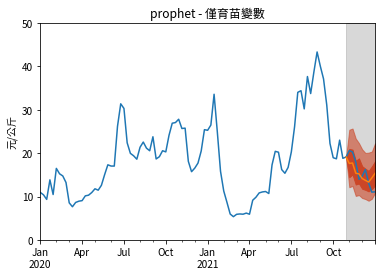

In [ ]:
fcst30 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=['LA_num', 'Temperature', 'Precp'], ci=0.3)
fcst60 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=['LA_num', 'Temperature', 'Precp'], ci=0.6)

fanchart(trs[-1], vas[-1], fcst30, fcst60, title='prophet - 僅育苗變數')

### 驗證資料

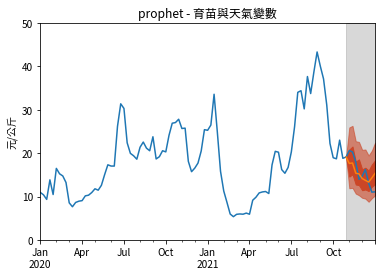

In [ ]:
fcst30 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=['LA_num', 'Temperature', 'Precp'], ci=0.3)
fcst60 = prophet_forecast(tr=trps[-1], va=vaps[-1], exo=['LA_num', 'Temperature', 'Precp'], ci=0.6)

fanchart(trs[-1], vas[-1], fcst30, fcst60, title='prophet - 育苗與天氣變數')

# 評估

## 準備評估資料

### 訓練資料

In [ ]:
dfins = pd.DataFrame({'y_real': trs[-1].price,
                      'y_sarimax': np.exp(results[-1].get_prediction().predicted_mean),
                      'y_prophet': np.exp(prophet_forecast(trps[-1]).yhat)})
dfins.tail()

,y_real,y_sarimax,y_prophet
2021-10-01,18.968285,22.790067,33.187853
2021-10-08,18.718567,16.033195,24.749402
2021-10-15,23.008165,17.930942,21.109855
2021-10-22,18.830983,24.478487,21.356169
2021-10-29,19.119969,16.749888,19.594124


### 驗證資料

In [ ]:
dfoos = pd.DataFrame({'y_real': vas[-1].price,
                      'y_sarimax': np.exp(sarimax_forcast(tr=trs[-1], va=vas[-1], ci=0.3).predicted_mean),
                      'y_prophet': np.exp(prophet_forecast(tr=trps[-1], va=vaps[-1]).yhat)})
dfoos.head()

,y_real,y_sarimax,y_prophet
2021-11-05,20.615359,15.554690,17.644919
2021-11-12,20.288235,15.138622,17.752219
2021-11-19,18.010898,11.244562,15.407024
2021-11-26,14.008714,10.591525,15.251011
2021-12-03,14.733079,10.686173,14.177256


## [評估標準](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

*   $\mbox{MSE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T(Y_t - \widehat{Y}_t)^2$

*   $\mbox{MAE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T|Y_t - \widehat{Y}_t|$

*   $\mbox{MAPE}(Y, \widehat{Y}) = \frac{1}{T} \sum_{t=1}^T\frac{|Y_t - \widehat{Y}_t|}{max(u_t, |Y_t|)}$



## 訓練資料

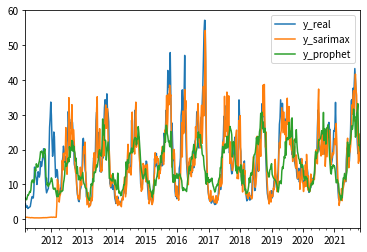

In [ ]:
dfins.plot()
plt.show()

In [ ]:
mse = [mean_squared_error(dfins.y_real, dfins.y_sarimax),
       mean_squared_error(dfins.y_real, dfins.y_prophet)]
mae = [mean_absolute_error(dfins.y_real, dfins.y_sarimax),
       mean_absolute_error(dfins.y_real, dfins.y_prophet)]
mape = [mean_absolute_percentage_error(dfins.y_real, dfins.y_sarimax),
        mean_absolute_percentage_error(dfins.y_real, dfins.y_prophet)]
dfv_ins = pd.DataFrame({'MSE': mse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_ins

,MSE,MAE,MAPE
SARIMAX,38.315079,4.026199,0.256260
prophet,63.482737,5.554545,0.366049


## 驗證資料

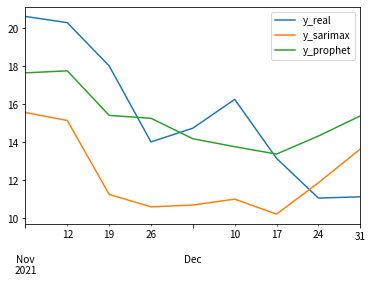

In [ ]:
dfoos.plot()
plt.show()

In [ ]:
mse = [mean_squared_error(dfoos.y_real, dfoos.y_sarimax),
       mean_squared_error(dfoos.y_real, dfoos.y_prophet)]
rmse = [np.sqrt(mean_squared_error(dfoos.y_real, dfoos.y_sarimax)),
        np.sqrt(mean_squared_error(dfoos.y_real, dfoos.y_prophet))]
mae = [mean_absolute_error(dfoos.y_real, dfoos.y_sarimax),
       mean_absolute_error(dfoos.y_real, dfoos.y_prophet)]
mape = [mean_absolute_percentage_error(dfoos.y_real, dfoos.y_sarimax),
      mean_absolute_percentage_error(dfoos.y_real, dfoos.y_prophet)]
dfv_oos = pd.DataFrame({'MSE': mse,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_oos

,MSE,RMSE,MAE,MAPE
SARIMAX,18.794983,4.335318,3.994496,0.248816
prophet,6.550445,2.559384,2.238885,0.154340


In [ ]:
# log(Price)
mse = [mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
       mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
rmse = [np.sqrt(mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax))),
        np.sqrt(mean_squared_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet)))]
mae = [mean_absolute_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
       mean_absolute_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
mape = [mean_absolute_percentage_error(np.log(dfoos.y_real), np.log(dfoos.y_sarimax)),
      mean_absolute_percentage_error(np.log(dfoos.y_real), np.log(dfoos.y_prophet))]
dfv_oos = pd.DataFrame({'MSE': mse,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE': mape}, index=['SARIMAX', 'prophet'])
dfv_oos

,MSE,RMSE,MAE,MAPE
SARIMAX,0.092360,0.303908,0.284876,0.103418
prophet,0.030591,0.174902,0.148365,0.056106


$\mbox{Lewis(1982)}$

$\mbox{MAPE} < 10\%： \mbox{Highly accurate forcasting}$

$ 10\%< \mbox{MAPE} < 20\%： \mbox{Good forecasting}$

$ 20\%< \mbox{MAPE} < 50\%： \mbox{Reasonable forecasting}$

$ \mbox{MAPE} > 50\%： \mbox{Week and inaccurate forecasting}$

Those Lewis numbers are fairly arbitrary, 
you can't just say that a 20% error is good forecasting because some guy wrote it in a book 40 years ago.The acceptable margin or error completely depends on the problem domain. In some situations a model that gives a 20% error will be great, in others it will be unusable. I know its tempting to rely on general rules like the ones you posted because they feel 'objective', but they are ultimately arbitrary and can't override common sense and domain expertise.

# 扇形圖

## 定義 fanchart function

In [ ]:
def fanchart(tr, va, fcst30, fcst60, start='2020', color='#199370'):
    """
    Args:
      tr: Training Set
      va: Validation Set
      yhat: Forecasting Price
      lastp: Price of last date
      lastci: Confidence Interval of last date
    Returns:
      plt.show()
    """
    lastp, lastci = connectpoint(tr)

    yhat = fcst30.iloc[:, 0]

    point_est = np.exp(yhat)
    point_est = point_est.append(lastp).sort_index()

    fig, ax = plt.subplots()
    tr[start:].price.plot(ax=ax, legend=False, color='black')
    # va.price.append(lastp).sort_index().plot(color='C0')

    point_est.plot(color='black', linestyle='--')
    plt.axvspan(point_est.index.min(), point_est.index.max(), color='grey', alpha=0.3)

    conf30 = fcst30.iloc[:, 1:]
    conf60 = fcst60.iloc[:, 1:]
    confs = [conf30, conf60] 

    for i, conf in enumerate(confs):
        conf = np.exp(conf)
        conf.columns = ['lower price', 'upper price']
        conf = conf.append(lastci).sort_index()
        plt.fill_between(conf.index, conf['lower price'], conf['upper price'],
                         color=color, alpha=(1-i/2.5), facecolor='black')

    ax.set_xlabel('')
    ax.set_ylabel('元/公斤')
    ax.set_ylim(0, 50)
    return plt.show()

## 繪製

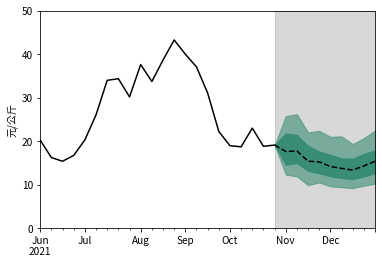

--------------------------------------------------


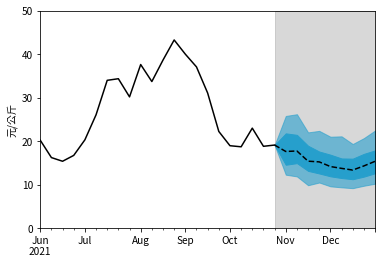

In [ ]:
fanchart(trs[-1], vas[-1], fcst30, fcst60, start='2021-06')
print('--------------------------------------------------')
fanchart(trs[-1], vas[-1], fcst30, fcst60, start='2021-06', color='#00adee')

# TODO

## Six Validation fanchart

### SARIMAX

In [ ]:
for i in range(len(vas)):
    fcst30 = sarimax_forcast(tr=trs[i], va=vas[i], ci=0.3) # todo: fix result[i]
    fcst60 = sarimax_forcast(tr=trs[i], va=vas[i], ci=0.6)

    fanchart(trs[i], vas[i], fcst30, fcst60, start='2020-06')

### prophet

In [ ]:
for i in range(len(vas)):
    fcst30 = prophet_forecast(tr=trps[i], va=vaps[i], ci=0.3)
    fcst60 = prophet_forecast(tr=trps[i], va=vaps[i], ci=0.6)

    fanchart(trs[i], vas[i], fcst30, fcst60, start='2020-06')

## Six Validation metrics

### SARIMAX

In [ ]:
mse, rmse, mae, mape = [], [], [], []
for i in range(len(vas)):
    y_real = vas[i].price # todo: fix result[i]
    y_sarimax = np.exp(sarimax_forcast(tr=trs[i], va=vas[i], ci=0.3).predicted_mean)
    
    mse.append(mean_squared_error(y_real, y_sarimax))
    rmse.append(np.sqrt(mean_squared_error(y_real, y_sarimax)))
    mae.append(mean_absolute_error(y_real, y_sarimax))
    mape.append(mean_absolute_percentage_error(y_real, y_sarimax))

sarimax_dfoos = pd.DataFrame({'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape})
sarimax_dfoos

,mse,rmse,mae,mape
0,81.573345,9.031796,7.226203,0.479770
1,34.265701,5.853691,4.160106,0.672453
2,70.934470,8.422260,7.646933,0.448295
3,631.143424,25.122568,23.916326,0.698768
4,303.699280,17.426970,15.968540,0.605121
5,18.794982,4.335318,3.994496,0.248816


### prophet

In [ ]:
mse, rmse, mae, mape = [], [], [], []
for i in range(len(vas)):
    y_real = vas[i].price
    y_prophet = np.exp(prophet_forecast(tr=trps[i], va=vaps[i]).yhat)
    
    mse.append(mean_squared_error(y_real, y_prophet))
    rmse.append(np.sqrt(mean_squared_error(y_real, y_prophet)))
    mae.append(mean_absolute_error(y_real, y_prophet))
    mape.append(mean_absolute_percentage_error(y_real, y_prophet))

prophet_dfoos = pd.DataFrame({'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape})
prophet_dfoos

,mse,rmse,mae,mape
0,133.374533,11.548789,8.896840,0.452974
1,1.505496,1.226987,0.968940,0.111882
2,15.388169,3.922776,3.135188,0.179569
3,87.409113,9.349284,8.127130,0.226990
4,108.764019,10.428999,7.960401,0.311790
5,6.621213,2.573172,2.254882,0.154277
